# Purpose
* Trying to reproduce the functionality of the `sim()` function in the `arm` (**A**pplied **R**egression and **M**ultilevel modeling) package Ref [1]
    - Original [source of `arm`](http://www.stat.columbia.edu/~gelman/arm/software/)
    - Someone's github clone of `arm`, [link to the `sim()` function](https://github.com/suyusung/arm/blob/master/R/sim.R) function
* Relevant discussions of `sim`
    - [Accepted answer to the question Simulating draws/data from a fitted model with factor/character level inputs](https://stackoverflow.com/a/42151309/3587374)
    - [Why does the sim function in Gelman's arm package simulate sigma from inverse chi square?](https://stats.stackexchange.com/questions/192996/why-does-the-sim-function-in-gelmans-arm-package-simulate-sigma-from-inverse-ch)
    
- From page 272 of Ref [1]: *Review of prediction for classical regression*
> In classical regression, prediction is simple: specify the predictor matrix $\tilde{X}$ for a set of new observations and then compute the linear predictor $\tilde{X}\beta$, then simulate the predictive data:
> * For linear regression, simulate independent normal errors $\tilde{\varepsilon}_i$ with mean 0 and standard deviation $\sigma$, and compute $y=\tilde{X}\beta+\tilde{\varepsilon}$; see Section 7.2.

Ref [1]. A. Gelman and J. Hill, Data Analysis Using Regression and Multilevel/Hierarchical Models, Cambridge University Press (2007). 

In [1]:
from typing import Optional, Tuple, Union

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2, t
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%load_ext watermark

In [3]:
%watermark -v -m -p numpy,matplotlib,pandas,sklearn,seaborn,statsmodels,scipy

Python implementation: CPython
Python version       : 3.8.11
IPython version      : 7.18.1

numpy      : 1.20.3
matplotlib : 3.4.3
pandas     : 1.3.2
sklearn    : 0.24.2
seaborn    : 0.11.2
statsmodels: 0.12.2
scipy      : 1.6.2

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.193-1-MANJARO
Machine     : x86_64
Processor   : 
CPU cores   : 4
Architecture: 64bit



In [4]:
%watermark -gb

Git hash: 4d07defde7464b78de811a0ea00f4e7600bf4ee7

Git branch: master



In [5]:
def resid_std(resid: np.array, df: int):
    return np.sqrt(np.sum(np.square(resid)) / df)


def display(result, digits=1):
    model = result.model.__class__.__name__
    formula = result.model.formula
    print(f"{model}(formular = {formula})\n")
    table = pd.concat([result.params, result.bse], axis=1).rename(
        columns={0: "coef.est", 1: "coef.se"}
    )
    with pd.option_context("display.float_format", "{{:0.{}f}}".format(digits).format):
        print(table)

    print(f"n = {int(result.nobs)}, k = {len(result.params)}")
    print(
        f"residual sd = {resid_std(result.resid, result.nobs - len(result.params)):0.1f}, R-Squared = {result.rsquared:0.2f}"
    )


def sim(result, n, **kwargs):
    df = result.nobs - len(result.params)
    sigmas = resid_std(result.resid, df) * np.sqrt((df) / chi2.rvs(df, size=n))
    betas = np.random.multivariate_normal(
        result.params, result.cov_params(**kwargs), size=n
    )
    return betas, sigmas


def score(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2_ = r2_score(y_true, y_pred)
    print(f"RMSE = {rmse:.2f}")
    print(f"R-Squared = {r2_:.2f}")


def _forward(X, weights, add_constant=False):
    return (
        np.dot(np.concatenate([np.ones((X.shape[0], 1)), X], axis=1), weights)
        if add_constant
        else np.dot(X, weights)
    )


def plot_fit(
    data: pd.DataFrame,
    x_col: str,
    y_col: str,
    weights: np.array,
    axis_labels: Optional[Tuple[str, str]] = (None, None),
    error: Optional[Tuple[int, np.array]] = None,
    return_fig_ax=False,
    jitter: Optional[Union[float, np.array]] = 0,
    ax: Optional = None,
    add_constant=False,
):
    fig, ax = plt.subplots() if ax is None else (None, ax)
    if error is not None:
        for i in range(error[0]):
            ax.plot(
                data[x_col],
                _forward(
                    data[x_col].values[:, None],
                    error[1][i, :],
                    add_constant=add_constant,
                ),
                c="xkcd:grey",
                alpha=0.15,
            )
    ax.plot(
        data[x_col],
        _forward(data[x_col].values[:, None], weights, add_constant=add_constant),
        c="k",
    )
    ax.scatter(data[x_col] + jitter, data[y_col])
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])

    if return_fig_ax:
        return fig, ax

In [6]:
font = {"size": 16}
mpl.rc("font", **font)

mpl.rcParams["figure.dpi"] = 100
# mpl.rcParams["font.sans-serif"] = "Arial"
# mpl.rcParams["font.family"] = "sans-serif"

## `statsmodel` OLS
* Taken from the `statsmodel`'s docs on [Ordinary Least Squares](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)

In [7]:
np.random.default_rng(9876789)

Generator(PCG64) at 0x7FDAB8474BA0

In [8]:
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x ** 2))
beta = np.array([1, 0.1, 10])
e = np.random.normal(size=nsample)

In [9]:
sm_ols_example = pd.DataFrame(X, columns=["x1", "x2"])

In [10]:
sm_ols_example = sm.add_constant(sm_ols_example)
sm_ols_example["Y"] = np.dot(sm_ols_example, beta) + e

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
results = smf.ols("Y ~ x1 + x2", data=sm_ols_example).fit()
display(results, digits=4)

OLS(formular = Y ~ x1 + x2)

           coef.est  coef.se
Intercept    1.1415   0.2649
x1           0.0130   0.1224
x2          10.0062   0.0118
n = 100, k = 3
residual sd = 0.9, R-Squared = 1.00


In [12]:
results.cov_params()

,Intercept,x1,x2
Intercept,0.070189,-0.027933,0.002316
x1,-0.027933,0.014993,-0.001404
x2,0.002316,-0.001404,0.000140


In [13]:
results.resid.std()

0.8916824241774342

In [14]:
sigma_hat = resid_std(results.resid, results.nobs - len(results.params))
sigma_hat

0.9008281242354061

In [15]:
beta = results.params
sigma = results.cov_params(scale=None)

In [16]:
B, s = sim(results, 1000, scale=None)

In [17]:
B.shape

(1000, 3)

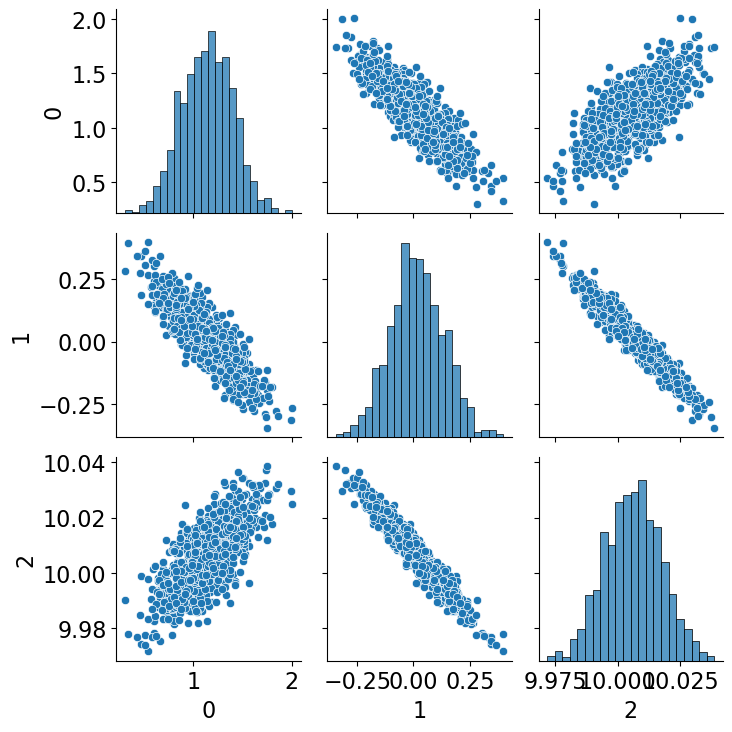

In [18]:
sns.pairplot(pd.DataFrame(B))

In [19]:
pd.DataFrame(B).mean(), pd.DataFrame(B).std()

(0     1.141041
 1     0.015388
 2    10.006087
 dtype: float64,
 0    0.262126
 1    0.119401
 2    0.011385
 dtype: float64)

In [20]:
pd.DataFrame(B).quantile([0.025, 0.975])

,0,1,2
0.025,0.632986,-0.215474,9.984349
0.975,1.637354,0.240517,10.028356


In [21]:
sigma_hat

0.9008281242354061

In [22]:
pd.DataFrame(s).mean(), pd.DataFrame(s).std()

(0    0.90898
 dtype: float64,
 0    0.068546
 dtype: float64)

### Verifying sigma sampling
* Not 100% sure which resid standard deviation, they both look similar
* I think `e = np.random.normal(size=nsample)` default scale is `1.` so both look correct
* Maybe I should try with a different scale

In [23]:
df_ = results.nobs - len(results.params)
sigmas_ = resid_std(results.resid, df_) * np.sqrt((df_) / chi2.rvs(df_, size=1000))
print(
    f"df = {df_} | mean sigma = {sigmas_.mean():0.2f} | std sigma = {sigmas_.std():0.2f}"
)

df = 97.0 | mean sigma = 0.91 | std sigma = 0.07


In [24]:
df_ = results.nobs - len(results.params)
sigmas_ = results.resid.std() * np.sqrt((df_) / chi2.rvs(df_, size=1000))
print(
    f"df = {df_} | mean sigma = {sigmas_.mean():0.2f} | std sigma = {sigmas_.std():0.2f}"
)

df = 97.0 | mean sigma = 0.90 | std sigma = 0.07


## 8.1 Fake-data simulation
- From Chapter 8, Simulation for checking statistical procedures and model fits. Ref [1]

In [25]:
rng = np.random.default_rng(9876789)

In [26]:
x = np.arange(1, 6)
beta = np.array([1.4, 2.3])
sigma = 0.9
e = rng.normal(scale=sigma, size=len(x))

In [27]:
data = pd.DataFrame(x, columns=["x"])
data = sm.add_constant(data)
data["y"] = np.dot(data, beta) + e
data

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,x,y
0,1.0,1,1.755502
1,1.0,2,5.260247
2,1.0,3,9.098717
3,1.0,4,11.034726
4,1.0,5,13.174619


In [28]:
results = smf.ols("y ~ x", data=data).fit()
display(results)

OLS(formular = y ~ x)

           coef.est  coef.se
Intercept      -0.5      0.8
x               2.9      0.2
n = 5, k = 2
residual sd = 0.8, R-Squared = 0.98


In [29]:
n_ = 1000
B, s = sim(results, n_, scale=None)

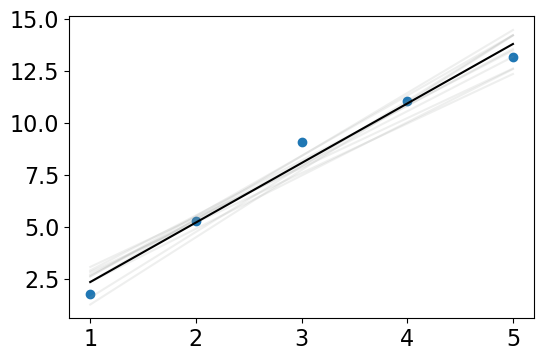

In [30]:
plot_fit(data, "x", "y", results.params.values, add_constant=True, error=(10, B))

In [31]:
B = pd.DataFrame(B)
s = pd.DataFrame(s)

In [32]:
print(f"a true = {beta[0]:9} | mean = {B.mean()[0]:0.1f} std = {B.std()[0]:0.1f}")
print(f"b true = {beta[1]:9} | mean = {B.mean()[1]:0.1f} std = {B.std()[1]:0.1f}")
print(f"sigma true = {sigma:5} | mean = {s.mean()[0]:0.1f} std = {s.std()[0]:0.1f}")

a true =       1.4 | mean = -0.6 std = 0.8
b true =       2.3 | mean = 2.9 std = 0.2
sigma true =   0.9 | mean = 1.1 std = 0.7


In [33]:
df_ = results.nobs - len(results.params)
sigmas_ = resid_std(results.resid, df_) * np.sqrt((df_) / chi2.rvs(df_, size=n_))
print(
    f"df = {df_} | mean sigma = {sigmas_.mean():0.2f} | std sigma = {sigmas_.std():0.2f}"
)

df = 3.0 | mean sigma = 1.02 | std sigma = 0.62


In [34]:
df_ = results.nobs - len(results.params)
sigmas_ = results.resid.std(ddof=int(df_)) * np.sqrt(df_ / chi2.rvs(df_, size=n_))
print(
    f"df = {df_} | mean sigma = {sigmas_.mean():0.1f} | std sigma = {sigmas_.std():0.1f}"
)

df = 3.0 | mean sigma = 1.3 | std sigma = 1.0


In [35]:
results.resid

0   -0.586718
1    0.056756
2    1.033955
3    0.108692
4   -0.612686
dtype: float64

In [36]:
np.sqrt(np.sum(np.square(results.resid)) / df_)

0.7753963800733337

In [37]:
results.resid.std(ddof=int(df_)), resid_std(results.resid, df_)

(0.9496627397904187, 0.7753963800733337)

In [38]:
cover_68 = np.abs(beta[1] - results.params[1]) < results.bse[1]
cover_95 = np.abs(beta[1] - results.params[1]) < 2 * results.bse[1]
print(f"68% coverage: {cover_68}\n95% coverage: {cover_95}")

68% coverage: False
95% coverage: False


In [39]:
n = 1000
cover_68 = np.zeros(n)
cover_95 = np.zeros(n)
for i in range(n):
    e = np.random.normal(scale=sigma, size=len(x))
    data = pd.DataFrame(x, columns=["x"])
    data = sm.add_constant(data)
    data["y"] = np.dot(data, beta) + e
    results = smf.ols("y ~ x", data=data).fit()
    cover_68[i] = np.abs(beta[1] - results.params[1]) < results.bse[1]
    cover_95[i] = np.abs(beta[1] - results.params[1]) < 2 * results.bse[1]

print(f"Assuming Normal, which is wrong")
print(f"68% coverage: {cover_68.mean()}\n95% coverage: {cover_95.mean()}")

/home/benda/anaconda3/envs/numpyro_play/lib/python3.8/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Assuming Normal, which is wrong
68% coverage: 0.622
95% coverage: 0.879


In [40]:
n = 1000
cover_68 = np.zeros(n)
cover_95 = np.zeros(n)
t_68 = t.ppf(0.84, len(x) - 2)
t_95 = t.ppf(0.975, len(x) - 2)
for i in range(n):
    e = np.random.normal(scale=sigma, size=len(x))
    data = pd.DataFrame(x, columns=["x"])
    data = sm.add_constant(data)
    data["y"] = np.dot(data, beta) + e
    results = smf.ols("y ~ x", data=data).fit()
    cover_68[i] = np.abs(beta[1] - results.params[1]) < t_68 * results.bse[1]
    cover_95[i] = np.abs(beta[1] - results.params[1]) < t_95 * results.bse[1]

print(f"Assuming t-dist")
print(f"68% coverage: {cover_68.mean()}\n95% coverage: {cover_95.mean()}")

Assuming t-dist
68% coverage: 0.687
95% coverage: 0.952


In [41]:
n = 1000
cover_68 = np.zeros((n,2))
cover_95 = np.zeros((n,2))
t_68 = t.ppf(0.84, len(x) - 2)
t_95 = t.ppf(0.975, len(x) - 2)
for i in range(n):
    e = np.random.normal(scale=sigma, size=len(x))
    data = pd.DataFrame(x, columns=["x"])
    data = sm.add_constant(data)
    data["y"] = np.dot(data, beta) + e
    results = smf.ols("y ~ x", data=data).fit()
    cover_68[i,0] = np.abs(beta[0] - results.params[0]) < t_68 * results.bse[0]
    cover_68[i,1] = np.abs(beta[1] - results.params[1]) < t_68 * results.bse[1]
    cover_95[i,0] = np.abs(beta[0] - results.params[0]) < t_95 * results.bse[0]
    cover_95[i,1] = np.abs(beta[1] - results.params[1]) < t_95 * results.bse[1]

print(f"Assuming t-dist")
print(f"68% coverage: {cover_68.mean(0)} std: {cover_68.std(0)}\n95% coverage: {cover_95.mean(0)} std: {cover_95.std(0)}")

Assuming t-dist
68% coverage: [0.675 0.691] std: [0.46837485 0.46208116]
95% coverage: [0.951 0.952] std: [0.21586802 0.21376623]


## Larger Data

In [42]:
rng = np.random.default_rng(9876789)
nsample = 100
x = np.linspace(0, 10, 100)
X = np.column_stack((x, x ** 2))
sigma = 2
beta = np.array([1, 0.1, 10])
e = rng.normal(scale=sigma, size=nsample)
sm_ols_example = pd.DataFrame(X, columns=["x1", "x2"])
sm_ols_example = sm.add_constant(sm_ols_example)
sm_ols_example["Y"] = np.dot(sm_ols_example, beta) + e

In [43]:
results = smf.ols("Y ~ x1 + x2", data=sm_ols_example).fit()
display(results, digits=4)

OLS(formular = Y ~ x1 + x2)

           coef.est  coef.se
Intercept    1.2193   0.5891
x1           0.2226   0.2722
x2           9.9854   0.0263
n = 100, k = 3
residual sd = 2.0, R-Squared = 1.00


In [44]:
n_ = 1000
B, s = sim(results, n_, scale=None)

In [45]:
B = pd.DataFrame(B)
s = pd.DataFrame(s)

In [46]:
print(f"b0 true = {beta[0]:9} | mean = {B.mean()[0]:0.2f} std = {B.std()[0]:0.2f}")
print(f"b1 true = {beta[1]:9} | mean = {B.mean()[1]:0.2f} std = {B.std()[1]:0.2f}")
print(f"b2 true = {beta[2]:9} | mean = {B.mean()[2]:0.2f} std = {B.std()[2]:0.2f}")
print(f"sigma true = {sigma:6} | mean = {s.mean()[0]:0.2f} std = {s.std()[0]:0.2f}")

b0 true =       1.0 | mean = 1.21 std = 0.60
b1 true =       0.1 | mean = 0.23 std = 0.28
b2 true =      10.0 | mean = 9.98 std = 0.03
sigma true =      2 | mean = 2.01 std = 0.15


### Verifying sigma sampling
* This comparison seems to verify Gelman's approach

In [47]:
df_ = results.nobs - len(results.params)
sigmas_ = resid_std(results.resid, df_) * np.sqrt(df_ / chi2.rvs(df_, size=n_))
print(
    f"df = {df_} | mean sigma = {sigmas_.mean():0.2f} | std sigma = {sigmas_.std():0.2f}"
)

df = 97.0 | mean sigma = 2.02 | std sigma = 0.15


In [48]:
df_ = results.nobs - len(results.params)
sigmas_ = results.resid.std(ddof=int(df_)) * np.sqrt(df_ / chi2.rvs(df_, size=n_))
print(
    f"df = {df_} | mean sigma = {sigmas_.mean():0.1f} | std sigma = {sigmas_.std():0.1f}"
)

df = 97.0 | mean sigma = 11.4 | std sigma = 0.8
